In [1]:
from glob import glob
import numpy as np

from tqdm import tqdm

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# featurized trajectories
path = "/Users/joshuafass/abl_backbone_torsions/*.npy"
fnames = glob(path)

In [3]:
def parse_run_and_clone_from_fname(fname):
    """Return a tuple of integers from the filename string"""
    actual_fname = fname.split("/")[-1]
    fname_after_run = actual_fname[3:]
    run_string, clone_string_ = fname_after_run.split("-")
    clone_string = clone_string_.split("_")[0][len("clone"):]
    
    return int(run_string), int(clone_string)
    
parse_run_and_clone_from_fname(fnames[0])

(0, 0)

In [4]:
# load the data and labels
Xs = []
ys = []

for fname in tqdm(fnames):
    run, clone = parse_run_and_clone_from_fname(fname)
    Xs.append(np.load(fname)[::5]) # for "training", taking every 5th frame
    ys.append(np.ones(len(Xs[-1])) * run)
X = np.vstack(Xs)
y = np.hstack(ys)
X.shape, y.shape, len(set(y))

100%|██████████| 1377/1377 [00:11<00:00, 121.90it/s]


((330351, 1004), (330351,), 95)

In [5]:
# get the number of frames per RUN
frames_per_RUN = np.zeros(max(y)+1)
for fname in tqdm(fnames):
    run, clone = parse_run_and_clone_from_fname(fname)
    n_frames = len(np.load(fname))
    frames_per_RUN[run] += n_frames

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
100%|██████████| 1377/1377 [00:13<00:00, 105.81it/s]


In [6]:
lda = LinearDiscriminantAnalysis()

In [7]:
lda.fit(X, y)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [8]:
lda.score(X,y)

0.98592103550466015

In [9]:
y_ = lda.predict(X)

/Users/joshuafass/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


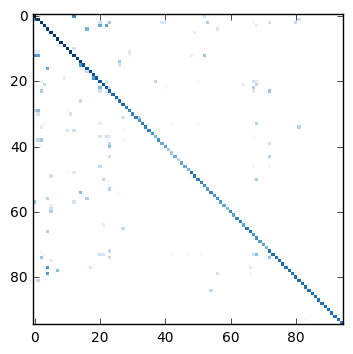

In [10]:
# see how well the learned linear classifier can separate trajectories by initial condition
c_m = confusion_matrix(y, y_)

plt.imshow(np.log(c_m), interpolation="none", cmap="Blues")

In [11]:
# classification accuracy
1.0 * np.trace(c_m) / np.sum(c_m)

0.9859210355046601

In [12]:
# fraction of nonzero matrix elements
(1.0 * np.sum(c_m!=0)) / np.prod(c_m.shape)

0.0260387811634349

In [13]:
def subtract_diag(matrix):
    return matrix - np.diag(np.diag(matrix))

In [14]:
# I guess, we can ask which RUNs are connected to at least one other RUN?

In [15]:
subtract_diag(c_m).sum(0)

array([605, 337, 116,  12, 803,  43,   0,  58,   0,   2,   7,   5, 580,
         0, 422,   0, 129,   4, 351,   1, 258,  17, 221, 160,   0,   0,
        35,  17,   0,   4,   0,   0,  19,   0,   0,   0,   0,  13,   0,
         4,   3,   0,   2,   0,   0,   0,   0,   1,   3,   2,   2,   1,
        46,  21,  11,   0,   9,   0,   0,   0,   0,   0,   0,   0,   2,
         0,   4,  43, 126,   0,   0,   0, 118,   0,   0,   0,   0,   0,
         0,   0,  10,  23,   0,   1,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0])

In [16]:
# how many RUNs are "disconnected" from all others?
sum(subtract_diag(c_m).sum(0) == 0), sum(subtract_diag(c_m).sum(0) != 0)

(50, 45)

In [17]:
def n_counts_in_set(run_set):
    """Compute the number of frames in a set of RUN indices"""
    return sum([frames_per_RUN[run] for run in run_set])

In [18]:
# next, we can identify the largest connected component?

import networkx as nx

graph = nx.DiGraph(c_m > 10)
(100 * sorted([n_counts_in_set(g) for g in nx.strongly_connected_components(graph)])[::-1] / np.sum(frames_per_RUN))

array([ 0.14389883,  0.06456316,  0.05654725, ...,  0.        ,
        0.        ,  0.        ])

In [19]:
# As we increase the threshold, what happens?

def get_percent_counts_in_largest_component(c_m, threshold=1):
    graph = nx.DiGraph(c_m >= threshold)
    return (100 * sorted([n_counts_in_set(g) for g in nx.strongly_connected_components(graph)])[-1] / np.sum(frames_per_RUN))


def plot_cc_size_as_fxn_of_threshold(c_m):
    thresholds = np.arange(1,500)
    cc_sizes = [get_percent_counts_in_largest_component(c_m, threshold) for threshold in tqdm(thresholds)]
    plt.plot(thresholds, cc_sizes)
    percent_counts_in_largest_RUN = 100.0 * np.max(frames_per_RUN) / np.sum(frames_per_RUN)
    plt.hlines(percent_counts_in_largest_RUN, thresholds[0], thresholds[-1], linestyle='--')
    plt.ylim(0, max(cc_sizes))
    plt.ylabel("% counts in largest strongly connected component")
    plt.xlabel("Threshold")

In [20]:
# now, let's do this for the full dataset, using the LDA model learned on a small subset of the data

y_full_true = []
y_full_pred = []
for fname in tqdm(fnames):
    run, clone = parse_run_and_clone_from_fname(fname)
    x = np.load(fname)
    
    y_full_pred.append(lda.predict(x))
    y_full_true.append(np.ones(len(x))*run)

100%|██████████| 1377/1377 [00:21<00:00, 64.67it/s] 


In [21]:
y_full_true = np.hstack(y_full_true)
y_full_pred = np.hstack(y_full_pred)

In [22]:
c_m = confusion_matrix(y_true=y_full_true, y_pred=y_full_pred)

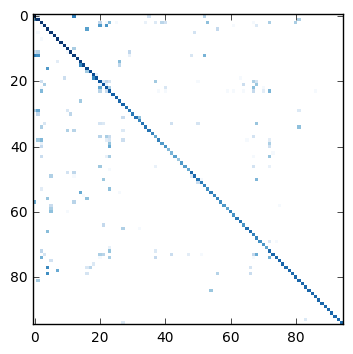

In [23]:
plt.imshow(np.log(c_m), interpolation="none", cmap="Blues")

100%|██████████| 499/499 [00:00<00:00, 1198.83it/s]


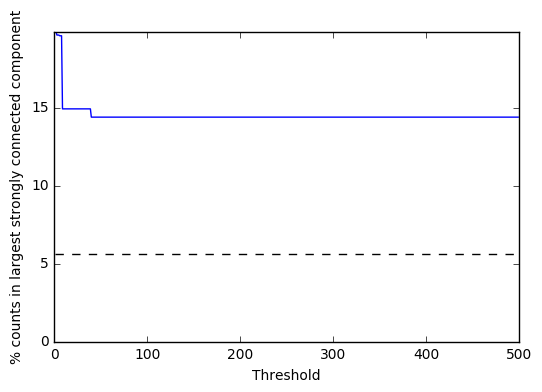

In [24]:
plot_cc_size_as_fxn_of_threshold(c_m)

In [28]:
# which RUNs are strongly connected components
graph = nx.DiGraph(c_m > 10)
[g for g in nx.strongly_connected_components(graph)]

[{52},
 {0, 1, 12, 81},
 {67},
 {80},
 {2, 20, 22, 23, 37, 39, 53, 72},
 {3},
 {4, 16, 56},
 {5},
 {6},
 {7},
 {8},
 {9},
 {10},
 {29},
 {11},
 {13},
 {14, 26},
 {15},
 {17},
 {18},
 {19},
 {68},
 {21, 64},
 {24},
 {25},
 {27},
 {28},
 {30},
 {32},
 {31},
 {33},
 {34},
 {35},
 {36},
 {38},
 {40},
 {41},
 {42},
 {43},
 {44},
 {45},
 {46},
 {47},
 {48},
 {49},
 {50},
 {51},
 {54},
 {55},
 {57},
 {58},
 {59},
 {60},
 {61},
 {62},
 {63},
 {65},
 {66},
 {69},
 {70},
 {71},
 {73},
 {74},
 {75},
 {76},
 {77},
 {78},
 {79},
 {82},
 {83},
 {84},
 {85},
 {86},
 {87},
 {88},
 {89},
 {90},
 {91},
 {92},
 {93},
 {94}]

In [29]:
# to-do: low-dimensional examples